In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn import svm
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
def clean_data(subject, training, artifactius = False):
    '''
    comment
    '''
    n_channels = 22    #Corresponding to the 22 EEG channels
    n_trials = 6*48    #Each session has 6 experimental runs with 48 trials each
    offset = 3*250     #record 3 seconds after trial marker
    win_length = 3*250 #stop after 3 seconds of recording
    
    class_return = np.zeros(n_trials)
    data_return = np.zeros((n_trials, n_channels, win_length))
    
    n_valid_trials = 0
    
    if training:
        Z = sio.loadmat('A0'+str(subject)+'T.mat')
    else:
        Z = sio.loadmat('A0'+str(subject)+'E.mat')
    Z_data = Z["data"]
    for i in range(Z_data.size):
        Z_data1 = Z_data[0,i]
        Z_data2 = [Z_data1[0,0]]
        Z_data3 = Z_data2[0]
        
        Z_X         = Z_data3[0]
        Z_trial     = Z_data3[1]
        Z_y         = Z_data3[2]
        Z_fs        = Z_data3[3]
        Z_classes   = Z_data3[4]
        Z_artifacts = Z_data3[5]
        Z_gender    = Z_data3[6]
        Z_age       = Z_data3[7]
        for trial in range(0,Z_trial.size):
            if Z_artifacts[trial]==0:
                data_return[n_valid_trials,:,:] = np.transpose(
                    Z_X[int(Z_trial[trial])+offset:(int(Z_trial[trial])+offset+win_length),:22]
                )
                class_return[n_valid_trials] = int(Z_y[trial])
                n_valid_trials +=1
                
    return data_return[0:n_valid_trials,:,:], class_return[0:n_valid_trials]

In [3]:
testData = clean_data(1,True)
print(testData[0].shape)
print(testData[1].shape)

(273, 22, 750)
(273,)


Classification on raw data to sanity check

In [4]:
def bandwidthpow(Data):
    x,y,z = Data.shape
    output = np.zeros((x,y))
    
    for i in range(x):
        output[i,:] = np.log(np.var(Data[i,:,:], axis = 1))
    return output

In [5]:
bandwidths = bandwidthpow(testData[0])

In [6]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(bandwidths, testData[1])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [7]:
predicts = clf.predict(bandwidths)

In [8]:
np.mean(predicts==testData[1])

0.4542124542124542

Well above chance, i.e. signals do explain to some degree.

# Try bandpass filtering

In [2]:
from scipy.signal import butter, lfilter


lowcut = 8
highcut = 30
fs = 250 # sampling frequency
order = 3
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
b, a = butter(order, [low, high], btype='band')


In [10]:
def reshape_signal(arr):
    x,y,z = arr.shape
    arr2 = np.stack(arr, axis = 1)
    arr2 = arr2.reshape((y, x*z))
    return arr2

In [11]:
sig = reshape_signal(testData[0])

In [12]:
sig_filter = lfilter(b, a, sig)

In [13]:
sig_filter = np.stack((sig_filter).reshape(22,sig.shape[1]//750,750),axis=1)

In [14]:
bandwidths = bandwidthpow(sig_filter)

In [15]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(bandwidths, testData[1])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [16]:
predicts = clf.predict(bandwidths)
np.mean(predicts==testData[1])

0.608058608058608

In [17]:
print(sig.shape, testData[0].shape, sig_filter.shape)

(22, 204750) (273, 22, 750) (273, 22, 750)


# Cleaning all data

In [18]:
Signal_list = []
Class_list = []
Session_lengths = []

for i in tqdm(range(1,10)):
    data = clean_data(i,True)
    sig = reshape_signal(data[0])
    sig_filter = lfilter(b, a, sig)
    sig_filter = np.stack((sig_filter).reshape(22,sig.shape[1]//750,750),axis=1)
    Signal_list.append(sig_filter)
    
    
    Class_list.append(data[1])
    Session_lengths.append((data[1].shape)[0])
    
    
    data = clean_data(i,False)
    
    sig = reshape_signal(data[0])
    sig_filter = lfilter(b, a, sig)
    sig_filter = np.stack((sig_filter).reshape(22,sig.shape[1]//750,750),axis=1)
    Signal_list.append(sig_filter)
    
    Class_list.append(data[1])
    Session_lengths.append((data[1].shape)[0])

In [19]:
Signals = np.concatenate(Signal_list)
Classes = np.concatenate(Class_list)

In [20]:
print(Signals.shape, Classes.shape,Session_lengths)

(4696, 22, 750) (4696,) [273, 281, 270, 283, 270, 273, 262, 228, 262, 276, 219, 215, 271, 277, 264, 271, 237, 264]


In [21]:
#np.savetxt("SignalData.csv", Signals.flatten(), delimiter=",")

In [22]:
#np.savetxt("ClassData.csv", Classes, delimiter=",")

In [23]:
Signals = Signals.astype("float32")

In [24]:
np.save("Signals.npy", Signals)

In [25]:
np.save("Class.npy", Classes)

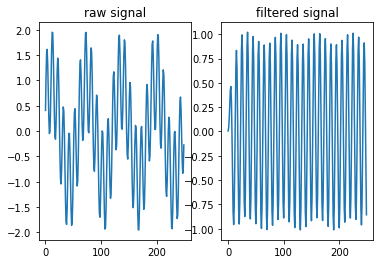

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 5 seconds of a 25 Hz signal with slow drift, sampling frequency 250 Hz
signal = np.array([np.sin(25 * np.arange(5 * 250) * 2 * np.pi / 250) + \
np.sin(4 * np.arange(5 * 250) * 2 * np.pi / 250 + .42),
          np.sin(25 * np.arange(5 * 250) * 2 * np.pi / 250) + \
np.sin(4 * np.arange(5 * 250) * 2 * np.pi / 250 + .42)])


# filtered signal
fsignal = lfilter(b, a, signal)[0]
fig, axs = plt.subplots(1, 2)
for ax, sig, lab in zip(axs,[signal[0], fsignal],['raw signal', 'filtered signal']):
    ax.plot(sig[:250])
    ax.set_title(lab)
plt.show()